In [1]:
import pandas as pd
import numpy as np
import random
import json
import os
import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import AlbertConfig, AlbertForPreTraining, load_tf_weights_in_albert,BertTokenizer,AlbertModel
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
"font.family": 'serif',
"font.size": 15,
"mathtext.fontset": 'stix',
"font.serif": ['SimSun'],
}
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import collections
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair
import sklearn.metrics as metrics

In [2]:
class Label_Dataset(Dataset):
    def __init__(self,data_x,data_y):
        self.data_x=data_x
        self.data_y=data_y
        
    def __len__(self):
        return len(self.data_x)
        
    def __getitem__(self,ind):
        label=self.data_y[ind]
        content=self.data_x[ind]
        return content,label

class MyModel_1(nn.Module):
    """
    Albert模型
    """
    def __init__(self, config):
        super(MyModel_1, self).__init__()
        self.albert = AlbertModel.from_pretrained(pretrained_weights)
        self.dropout=nn.Dropout(p=0.1,inplace=False)
        self.classifier=nn.Linear(768,config.number_class,bias=True)
        self.sigmoid=nn.Sigmoid()
    def forward(self,x,attention_mask):
        _,out=self.albert(x,attention_mask=attention_mask)[:2]
        out=self.dropout(out)
        out=self.classifier(out)
        out=self.sigmoid(out)
        return out

def get_result(Y_test, Y_pred):
    """
    计算评价指标
    """
    test_acc_rate=metrics.accuracy_score(Y_test, Y_pred)
    test_pre_rate=metrics.precision_score(Y_test, Y_pred)
    test_recall_rate=metrics.recall_score(Y_test, Y_pred)
    test_f1=metrics.f1_score(Y_test, Y_pred)
    return test_acc_rate,test_pre_rate,test_recall_rate,test_f1

def get_each_label_result(trues,preds):
    preds=np.array(preds)
    trues=np.array(trues)
    
    epoch_result=[]
    for i in range(len(class_list)):
        true_i=trues[:,i]
        pred_i=preds[:,i]
        result_i=get_result(true_i, pred_i)
        epoch_result.append(result_i)
    return [trues,preds],np.array(epoch_result)

def plotHeatMap(Y_test, Y_pred):
    """
    绘制混淆矩阵
    """
    con_mat = metrics.confusion_matrix(Y_test, Y_pred).astype(float)
    for i in range(len(con_mat)):
        con_mat[i]=np.round(con_mat[i]/sum(con_mat[i]),4)
    
    # 绘图
    plt.figure(figsize=(8,8))
    sns.heatmap(con_mat, annot=True, fmt='.4g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(range(len(class_list)),class_list)
    plt.yticks(range(len(class_list)),class_list)
    plt.savefig('./test_混淆矩阵.png',dpi=400)
    plt.show()

def test_func(model,test_dataloader):
    model.eval()
    test_loss=0
    with torch.no_grad():
        count=0
        test_true,test_pred=[],[]
        for i,(x,y) in enumerate(test_dataloader):
            token_x=tokenizer.batch_encode_plus(x,max_length=max_length,pad_to_max_length=True,truncation=True)
            token_x_input_ids=token_x['input_ids']
            token_x_attention_mask=token_x['attention_mask']
            token_x_input_ids=torch.tensor(token_x_input_ids).to(device)
            token_x_attention_mask=torch.tensor(token_x_attention_mask).to(device)
            token_y=y.to(device)
            
            out=model(token_x_input_ids, token_x_attention_mask)
            loss=loss_func(out,token_y.float())#计算损失值
            test_loss+=loss.item()
            count+=len(x)
    
            #收集结果
            pred=(out>0.5).int().detach().to('cpu').numpy()
            true=token_y.detach().to('cpu').numpy()
            test_pred+=list(pred)
            test_true+=list(true)
    test_true_pred,test_result=get_each_label_result(test_true,test_pred)
    test_result_df=pd.DataFrame(test_result,index=class_list,columns=['acc','pre','rec','f1'])
    return test_result_df,test_true_pred,test_loss/count

In [41]:
data_path='./CSL_FullAnnotation1/'
file_path=os.listdir(data_path)

invalid_file=[]
all_data=pd.DataFrame({})
all_data_dialog=pd.DataFrame({})
file_score={}
error_dict={}
for file in tqdm(file_path):
    file_p=data_path+file
    if '.DS_Store' in file_p:
        continue
    for excel in os.listdir(file_p):
        if ('.xlsx' not in excel) or ('$' in excel):
            continue
        excel_path=file_p+'/'+excel

        data=pd.read_excel(excel_path)
        #============剔除缺少Label列的文件===============
        if 'Label' not in data.columns:
            error_dict[excel_path]='缺少Label列'
            continue
            
        #===========找分数===========
        data_data=data[data['Label'].isna()==False]
        ii=None
        for i in data_data['Label']:
            try:
                ii=int(i)
                break
            except:
                
                continue

        #========剔除没有分数的文件============
        if ii is not None:
            score=ii
            file_score[excel_path]=score
        else:
            error_dict[excel_path]='缺少分数'
            continue

        #=======剔除没有Speaker列的文件=============
        if (data['Speaker'].isna()==False).sum()==0:
            invalid_file.append(excel_path)
            error_dict[excel_path]='没有Speaker列'
            continue
        data['Speaker']=data['Speaker'].fillna(method='ffill')
        data['Speaker']=data['Speaker'].fillna(method='backfill')

        #=========剔除没有LabelLevel列的文件============
        try:
            data_1=data[data['LabelLevel'].isin(['Token level','Utterance level'])]
            data_dislog=data[data['LabelLevel']=='Dialogue level']
            data_dislog['file']=[excel_path]*len(data_dislog)
            all_data_dialog=pd.concat([all_data_dialog,data_dislog])
        except:
            error_dict[excel_path]='没有LabelLevel列'
            continue

        #======删除Speaker的缩进=========
        data_1['Speaker']=data_1['Speaker'].apply(lambda x: x.strip())
        
        #------------合并类别-------------
        if 'R' in list(data_1['Speaker']):
            data_1['Speaker']=data_1['Speaker'].apply(lambda x: np.nan if x=='R' else x)
            data_1['Speaker']=data_1['Speaker'].fillna(method='ffill')
            data_1['Speaker']=data_1['Speaker'].fillna(method='backfill')
        dicts_list={'梦莹':'秀莹','SPK_3':'SPK_2','美丽':'美容','方湾':'芳湾','Jing':'克姆','雅克':'雅哈','方兴':'芳湾'}
        for iii,jjj in dicts_list.items():
            if iii in list(data_1['Speaker']):
                data_1['Speaker']=data_1['Speaker'].apply(lambda x: jjj if x==iii else x)

        #=========给文本添加对话者身份========
        name_list=list(data_1['Speaker'].drop_duplicates())
        index_list=['A','B','C','D']
        name_dict={}
        if len(name_list)!=2:
            print(name_list,excel_path)
        for index_i,name in enumerate(name_list):
            name_dict[name]=index_list[index_i]
        content_2_label_dict=collections.defaultdict(list)
        
        for name,AB in name_dict.items():
            name_data=data_1[data_1['Speaker']==name]
            for _,label,_, content in name_data.values:
                content_2_label_dict[AB+'-'+content].append(label)
        new_dict_1={}
        for i,j in content_2_label_dict.items():
            new_dict_1[i]=['|'.join(j),i]
        new_df=pd.DataFrame(new_dict_1).T
        new_df.index=range(len(new_df))

        #=========添加文件名===========
        new_df['file']=[excel_path]*len(new_df)
        all_data=pd.concat([all_data,new_df])

  0%|          | 0/24 [00:00<?, ?it/s]

['菊明奎'] ./CSL_FullAnnotation1/Jodie_new_results/annotations low 2-4.xlsx
['隋文熙'] ./CSL_FullAnnotation1/已标注/Low1-6.xlsx
['图雅'] ./CSL_FullAnnotation1/第二次正式数据/Beginner1-5 F.xlsx


In [60]:
all_data_dialog.to_csv('./all_data_dialog.csv',index=False)
file_score_df=pd.DataFrame([file_score]).T
file_score_df.to_csv('./file_score.csv')

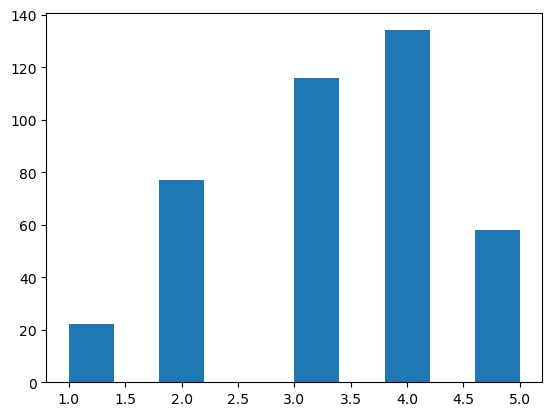

In [50]:
plt.hist(file_score_df[0])
plt.show()

In [4]:
len(set(all_data['file'])),len(invalid_file),len(error_dict)

(406, 1, 2)

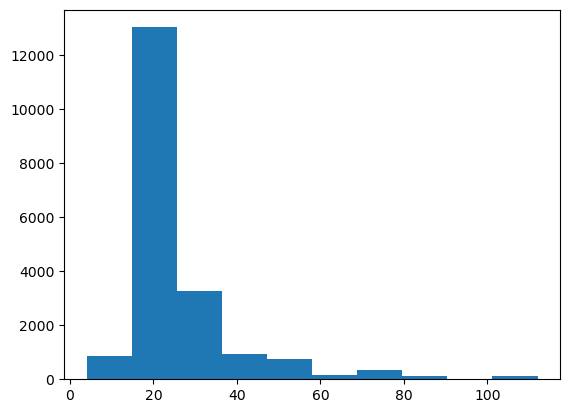

In [5]:
plt.hist([len(i) for i in all_data[1]])
plt.show()

In [6]:
#==============划分训练集、验证集和测试集的文件==========
all_file_list=list(set(all_data['file']))
train_file,test_file=train_test_split(all_file_list,train_size=0.8)
train_file,valid_file=train_test_split(train_file,train_size=0.85)

#========================加标签=====================
class_list=list(set('|'.join(all_data[0]).split('|')))
data_y=np.zeros(shape=(len(all_data),len(class_list)))
data_x=all_data.values[:,1]
data_f=all_data.values[:,2]

for label_i,labels in enumerate(all_data.values[:,0]):
    labels_list=labels.split('|')
    for jjj in labels_list:
        data_y[label_i,class_list.index(jjj)]=1

new_data_df=pd.concat([pd.DataFrame(data_y),pd.DataFrame(data_x,columns=['text']),pd.DataFrame(data_f,columns=['file'])],axis=1)

#找出训练集和测试集
train_df=new_data_df[new_data_df['file'].isin(train_file)]
valid_df=new_data_df[new_data_df['file'].isin(valid_file)]
test_df=new_data_df[new_data_df['file'].isin(test_file)]

#数据打包
traindataset=Label_Dataset(train_df.values[:,-2],train_df[train_df.columns[:-2]].values)
validdataset=Label_Dataset(valid_df.values[:,-2],valid_df[valid_df.columns[:-2]].values)
testdataset=Label_Dataset(test_df.values[:,-2],test_df[test_df.columns[:-2]].values)
train_dataloader=DataLoader(traindataset,batch_size=64,shuffle=True)
valid_dataloader=DataLoader(validdataset,batch_size=64,shuffle=True)
test_dataloader=DataLoader(testdataset,batch_size=64,shuffle=False)

new_data_df.columns=class_list+['text','file']
new_data_df.to_csv('./new_data_df.csv',index=False)

In [7]:
#=============加载分词器=============
pretrained_weights='./albert/small//'
tokenizer=BertTokenizer.from_pretrained(pretrained_weights)
config=AlbertConfig.from_pretrained(pretrained_weights,num_labels=len(class_list))
config.number_class=len(class_list)

#============加载模型==============
max_length=128
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device='cpu'
model=MyModel_1(config)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_func = torch.nn.BCELoss()#torch.nn.CrossEntropyLoss()
model=model.to(device)

Some weights of AlbertModel were not initialized from the model checkpoint at ./albert/small// and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
loss_list,result_dict={},{}
best_f1=0
for epoch in range(15):
  
    model.train()
    loss_total=0
    preds=[]
    trues=[]
    count=0
    for (x,y) in tqdm(train_dataloader):
        token_x=tokenizer.batch_encode_plus(x,max_length=max_length,pad_to_max_length=True,truncation=True)
        token_x_input_ids=token_x['input_ids']
        token_x_attention_mask=token_x['attention_mask']
        token_x_input_ids=torch.tensor(token_x_input_ids).to(device)
        token_x_attention_mask=torch.tensor(token_x_attention_mask).to(device)
        token_y=y.to(device)

        optimizer.zero_grad()
        out=model(token_x_input_ids, token_x_attention_mask)#预测
        loss=loss_func(out,token_y.float())#计算损失值

        loss.backward()#反馈损失
        optimizer.step()#迭代
        loss_total+=loss.item()
        count+=len(x)

        #收集结果
        pred=(out>0.5).int().detach().to('cpu').numpy()
        true=token_y.detach().to('cpu').numpy()
        preds+=list(pred)
        trues+=list(true)

    train_true_pred,train_result=get_each_label_result(trues,preds)
    train_result_df=pd.DataFrame(train_result,index=class_list,columns=['acc','pre','rec','f1'])
    train_loss=loss_total/count

    valid_result_df,valid_true_pred,valid_loss=test_func(model,valid_dataloader)

    #=================记录所有结果=============
    loss_list[epoch+1]=[train_loss,valid_loss]
    result_dict[epoch+1]={'train':train_result_df,'valid':valid_result_df}
    if valid_result_df.mean()['f1']>best_f1:
        best_f1=valid_result_df.mean()['f1']
        torch.save(model, 'best_model.pth')
    print(f'epoch={epoch+1}, Train loss: {train_loss}, Valid loss: {valid_loss}, Valid result: {valid_result_df.mean()}')

  0%|          | 0/212 [00:00<?, ?it/s]

epoch=1, Train loss: 0.0024797069730444392, Valid loss: 0.001532811033860167, Valid result: acc    0.970525
pre    0.164165
rec    0.155696
f1     0.159750
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=2, Train loss: 0.0014954482853298122, Valid loss: 0.0012219040487689257, Valid result: acc    0.975659
pre    0.434461
rec    0.274081
f1     0.314673
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=3, Train loss: 0.0012691754328085045, Valid loss: 0.0011665996777713659, Valid result: acc    0.976062
pre    0.546740
rec    0.409877
f1     0.451675
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=4, Train loss: 0.0011377467358083268, Valid loss: 0.0011285058223836325, Valid result: acc    0.976465
pre    0.603840
rec    0.399246
f1     0.455271
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=5, Train loss: 0.0010574993194228564, Valid loss: 0.0010087224825514548, Valid result: acc    0.978202
pre    0.625858
rec    0.441038
f1     0.487601
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=6, Train loss: 0.0009267758311065486, Valid loss: 0.0009737021701978283, Valid result: acc    0.979863
pre    0.665675
rec    0.480044
f1     0.534386
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=7, Train loss: 0.0008460206544053983, Valid loss: 0.0009666960446394311, Valid result: acc    0.979737
pre    0.635381
rec    0.510956
f1     0.544503
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=8, Train loss: 0.000755178457910771, Valid loss: 0.0009770188203056733, Valid result: acc    0.980165
pre    0.695794
rec    0.549080
f1     0.590400
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=9, Train loss: 0.0007278571112869462, Valid loss: 0.0009641298739913967, Valid result: acc    0.980039
pre    0.654755
rec    0.519736
f1     0.566632
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=10, Train loss: 0.0006753791735243441, Valid loss: 0.0009634549558114679, Valid result: acc    0.979863
pre    0.679821
rec    0.549230
f1     0.596626
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=11, Train loss: 0.0005732391372838312, Valid loss: 0.0009710709344966249, Valid result: acc    0.979788
pre    0.673864
rec    0.575655
f1     0.610945
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=12, Train loss: 0.0005162356644169705, Valid loss: 0.0009685289737345757, Valid result: acc    0.980568
pre    0.677654
rec    0.588227
f1     0.625789
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=13, Train loss: 0.0004801599109151461, Valid loss: 0.0009325818082545008, Valid result: acc    0.981147
pre    0.687695
rec    0.608815
f1     0.632877
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=14, Train loss: 0.000433042431100201, Valid loss: 0.0009836625522343901, Valid result: acc    0.980870
pre    0.684615
rec    0.594459
f1     0.629334
dtype: float64


  0%|          | 0/212 [00:00<?, ?it/s]

epoch=15, Train loss: 0.0004210057834228543, Valid loss: 0.0009680200162622364, Valid result: acc    0.980341
pre    0.657201
rec    0.602732
f1     0.626848
dtype: float64


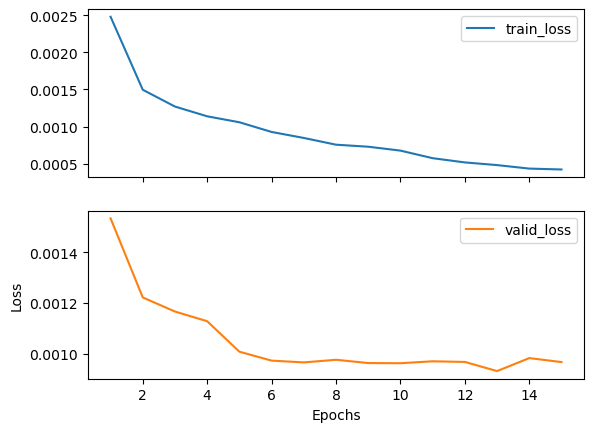

In [13]:
#================损失值变化曲线可视化==================
loss_list_df=pd.DataFrame(loss_list,index=['train_loss','valid_loss']).T
loss_list_df.to_csv('./loss_list_df.csv')
loss_list_df.plot(subplots=True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Loss.png',dpi=400)
plt.show()

In [16]:
result_dict[15]['train']

,acc,pre,rec,f1
epistemic copulas,0.997709,0.929688,0.843972,0.884758
formulaic responses,0.976799,0.875294,0.781513,0.825749
question-based responses,0.986478,0.834008,0.591954,0.692437
non-factive verb phrase structure,0.999631,0.000000,0.000000,0.000000
impersonal subject + non-factive verb + NP,0.997636,0.909091,0.243902,0.384615
reference word,0.990838,0.985164,0.989927,0.987540
routinized resources,0.983375,0.783133,0.706522,0.742857
noun & verb collocation in proper form,0.985961,0.970863,0.958687,0.964736
collaborative finishes,0.995271,0.802083,0.631148,0.706422
tense choice to indicate interactive aims,0.994680,0.957211,0.930663,0.943750


In [17]:
result_dict[15]['valid']

,acc,pre,rec,f1
epistemic copulas,0.995570,0.700000,0.736842,0.717949
formulaic responses,0.951269,0.559441,0.579710,0.569395
question-based responses,0.972614,0.500000,0.426471,0.460317
non-factive verb phrase structure,0.999195,0.000000,0.000000,0.000000
impersonal subject + non-factive verb + NP,0.998792,0.000000,0.000000,0.000000
reference word,0.987515,0.982379,0.983462,0.982920
routinized resources,0.971808,0.564516,0.448718,0.500000
noun & verb collocation in proper form,0.972211,0.953642,0.900000,0.926045
collaborative finishes,0.988321,0.565217,0.406250,0.472727
tense choice to indicate interactive aims,0.990737,0.915663,0.826087,0.868571


TypeError: only length-1 arrays can be converted to Python scalars

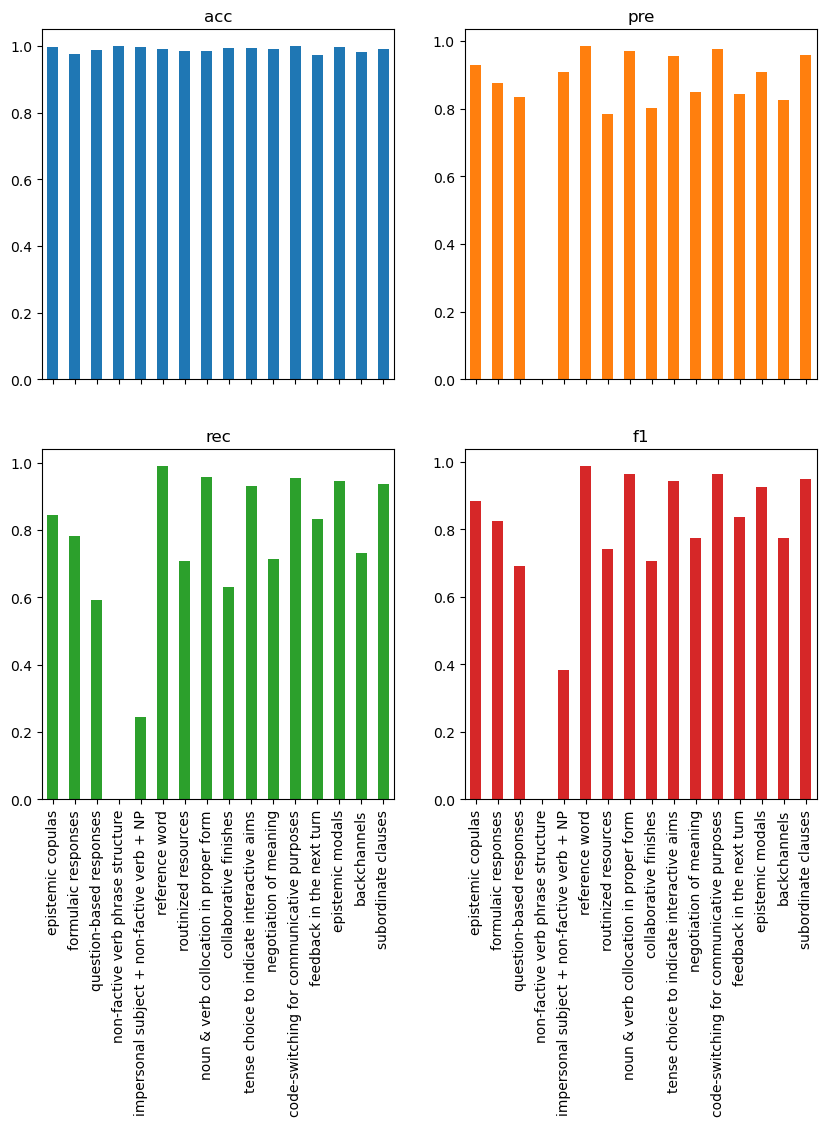

In [18]:
plt.figure(train_result_df.plot.bar(subplots=True,figsize=(10,10),layout=(2,2),legend=False))

In [19]:
best_model=torch.load('best_model.pth')

In [20]:
test_result_df,test_true_pred,test_loss=test_func(best_model,test_dataloader)

In [22]:
test_result_df.to_csv('./test_result_df.csv')

In [34]:
test_pred_df=pd.concat([pd.DataFrame(test_true_pred[1],
                                     index=test_df.index,
                                     columns=class_list),test_df[test_df.columns[-2:]]],axis=1)
test_pred_df.to_csv('./test_pred_df.csv')

In [65]:
#读取所有的数据
all_data_dialog_1=pd.read_csv('./all_data_dialog.csv')
all_score_1=pd.read_csv('./file_score.csv')
all_score_1.columns=['file','score']

In [64]:
all_score_1

,Unnamed: 0,0
0,./CSL_FullAnnotation1/Annotated new data/begin...,3
1,./CSL_FullAnnotation1/Annotated new data/begin...,3
2,./CSL_FullAnnotation1/Annotated new data/begin...,4
3,./CSL_FullAnnotation1/Annotated new data/begin...,3
4,./CSL_FullAnnotation1/Annotated new data/begin...,4
...,...,...
402,./CSL_FullAnnotation1/第二次正式数据/Low2-3 F.xlsx,4
403,./CSL_FullAnnotation1/第二次正式数据/Low2-4.xlsx,5
404,./CSL_FullAnnotation1/第二次正式数据/Low2-5.xlsx,4
405,./CSL_FullAnnotation1/第二次正式数据/Low2-6.xlsx,4
